In [1]:
from collect_data import collect_ecos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler

# 1. Get data

In [29]:
ecos_df = collect_ecos('D:/stock-market-index-prediction')

In [30]:
ecos_df

,TIME,한국은행 기준금리,KOSPI_종가,KOSDAQ_종가,CD(91일),국고채(10년),"회사채(3년, AA-)",KOSPI_거래대금 일평균,KOSDAQ_거래대금 일평균,KOSPI_주가이익비율 3),...,개인(순매수),외국인(순매수) 3),투자자 예탁금,파생상품거래 예수금 1),RP,위탁매매 미수금,신용융자 잔고 2),계약금액(일평균) 1),거래대금(일평균)(CALL 옵션),거래대금(일평균)(PUT 옵션)
0,198701,NaN,NaN,NaN,NaN,NaN,12.65,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,198702,NaN,NaN,NaN,NaN,NaN,12.65,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,198703,NaN,NaN,NaN,NaN,NaN,12.65,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,198704,NaN,NaN,NaN,NaN,NaN,12.65,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,198705,NaN,NaN,NaN,NaN,NaN,12.65,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,202112,1,2977.65,1033.98,1.27,2.187,2.41,9919548905,11222767614,12.72,...,-6368816,3398687,67530709,10785489,83396190,321040,23088636,30072196,311706,300854
420,202201,1.25,2663.34,872.87,1.39,2.492,2.632,11282725350,9368232570,12.14,...,4387758,-1461738,70344739,11808123,89550629,302391,21672907,28714128,300928,417528
421,202202,1.25,2699.18,881.07,1.5,2.69,2.873,10950191761,7709877157,12.32,...,470383,798268,63425412,11335916,89976992,248013,20896955,27739423,319891,393760
422,202203,1.25,2757.65,944.53,1.5,2.784,3.028,11079648342,8807031471,12.58,...,6501104,-5117355,63282649,11167706,83072286,217343,22042773,25797595,242393,310523


# 2. Preprocessing

In [31]:
# nan이 있는 행 삭제
ecos_df.dropna(inplace=True)
ecos_df.reset_index(drop=True, inplace=True)

# 칼럼명 내 '(', ')' 기호 -> '[', ']'로 수정
ecos_df_cols_new = list(ecos_df.columns)
for idx, i in enumerate(ecos_df_cols_new):
    temp_name = re.sub('[\( ]', '_', i)
    temp_name = re.sub('[\)\,\-]', '', temp_name)
    ecos_df_cols_new[idx] = temp_name

ecos_df.columns = ecos_df_cols_new

In [32]:
# 칼럼 type numeric으로 수정
ecos_df = ecos_df.apply(pd.to_numeric, errors='coerce')

In [33]:
'''
다음 월(next month)의 종가를 값으로 갖는 새로운 칼럼 만들기
'''
# 기존 칼럼 갯수
column_index = len(ecos_df.columns)

# 새로운 칼럼에 임시로 0.1값 부여(float으로 만들기 위해)
ecos_df.insert(column_index, column='KOSPI_NEW', value=0.1)
#ecos_df.insert(column_index+1, column='KOSDAQ_NEW', value=0.1)

# 새로운 칼럼에 다음 월 종가 기입
for i in range(len(ecos_df)-1):
    ecos_df.loc[i, 'KOSPI_NEW'] = ecos_df.loc[i+1, 'KOSPI_종가']
    #ecos_df.loc[i, 'KOSDAQ_NEW'] = ecos_df.loc[i+1, 'KOSDAQ_종가']

# 마지막 행 삭제(새로운 칼럼에 값이 없기 때문)
ecos_df.drop(labels=ecos_df.index[-1], axis='index', inplace=True)

# 코스피/코스닥 칼럼명 변경
ecos_df.rename(columns={'KOSPI_종가':'KOSPI', 'KOSDAQ_종가':'KOSDAQ'}, inplace=True) 

In [34]:
# 전월 대비 증가했으면 1, 감소했으면 0부여
for i in range(len(ecos_df)):
    if ecos_df.loc[i, 'KOSPI'] <= ecos_df.loc[i, 'KOSPI_NEW']:
        ecos_df.loc[i, 'KOSPI_BINARY'] = 1
    else:
        ecos_df.loc[i, 'KOSPI_BINARY'] = 0

    # if ecos_df.loc[i, 'KOSDAQ'] <= ecos_df.loc[i, 'KOSDAQ_NEW']:
    #     ecos_df.loc[i, 'KOSDAQ_BINARY'] = 1
    # else:
    #     ecos_df.loc[i, 'KOSDAQ_BINARY'] = 0

# BINARY 칼럼 type을 int로
ecos_df = ecos_df.astype({'KOSPI_BINARY':'int'})
#ecos_df = ecos_df.astype({'KOSPI_BINARY':'int', 'KOSDAQ_BINARY':'int'})

In [35]:
# # 전년 동기 대비 값으로 변경하기
# ecos_df_cols = list(ecos_df.columns)
# not_yoy_cols = ['TIME', '한국은행_기준금리', 'KOSPI_NEW', 'KOSPI_BINARY']

# for c in ecos_df_cols:
#     if c in not_yoy_cols:
#         continue
#     else:
#         ecos_df[f'{c}_yoy'] = None
#         for i in range(12, len(ecos_df)):
#             yoy_value = (ecos_df.loc[i, c] - ecos_df.loc[i-12, c])/ecos_df.loc[i-12, c]
#             ecos_df.loc[i, f'{c}_yoy'] = yoy_value
# erase_cols = ecos_df_cols
# for i in not_yoy_cols:
#     erase_cols.remove(i)
# ecos_df = ecos_df.loc[12: ]
# ecos_df = ecos_df[ecos_df.columns.difference(erase_cols)]
# ecos_df.reset_index(drop=True, inplace=True)

# # 칼럼 type numeric으로 수정
# ecos_df = ecos_df.apply(pd.to_numeric, errors='coerce')

# ecos_df

# #ecos_df.loc[12:,:].isna().any().sum()

# 3. 스케일링

In [36]:
'''
22.05.03. 추가 작업
- 사유: 모델링 중 스케일링이 안 되어 있음을 발견
- 작업 내용: ecos_df를 상관분석 하기 전에 스케일링
- 유의점: py에서는 return에 코스피 max, min값을 포함해야 한다.
'''

ecos_df_cols = list(ecos_df.columns)
# 각 값들 소수점 둘째자리에서 반올림
ecos_df = ecos_df.apply(lambda x : round(x, 2))

# 스케일링 진행
scaler = MinMaxScaler()
scaler.fit(ecos_df)
'''
scaler에서 inf값 때문에 오류가 난다면, 해당 지표는 삭제하는 게 좋다고 생각한다. 결측값 처리하기가 참 애매하다. 그냥 빼는 게 낫다
 -> 신용 대주 잔고 삭제.
'''

# 코스피 max, min값
kospi_col_idx = ecos_df_cols.index('KOSPI')
scaler_kospi = {
    'max': scaler.data_max_[kospi_col_idx], 
    'min': scaler.data_min_[kospi_col_idx]
    }

ecos_df = scaler.transform(ecos_df)

# 데이터프레임화
ecos_df = pd.DataFrame(ecos_df)
ecos_df.columns = ecos_df_cols

In [37]:
ecos_df

,TIME,한국은행_기준금리,KOSPI,KOSDAQ,CD_91일,국고채_10년,회사채_3년_AA,KOSPI_거래대금_일평균,KOSDAQ_거래대금_일평균,KOSPI_주가이익비율_3,...,투자자_예탁금,파생상품거래_예수금_1,RP,위탁매매_미수금,신용융자_잔고_2,계약금액_일평균_1,거래대금_일평균_CALL_옵션,거래대금_일평균_PUT_옵션,KOSPI_NEW,KOSPI_BINARY
0,0.000000,0.684211,0.150785,0.523719,0.651852,0.905858,0.557803,0.133986,0.128401,0.110236,...,0.080661,0.019894,0.000487,0.994870,0.005722,0.113687,0.212613,0.125723,0.138142,0.0
1,0.000625,0.736842,0.138142,0.512937,0.670370,0.843096,0.533237,0.073347,0.090498,0.108993,...,0.064424,0.008211,0.001543,1.000000,0.005518,0.149018,0.204223,0.150988,0.132774,0.0
2,0.001249,0.736842,0.132774,0.489471,0.674074,0.872385,0.528902,0.034976,0.068318,0.104849,...,0.050511,0.001297,0.000000,0.731455,0.004496,0.110825,0.101806,0.094471,0.159694,1.0
3,0.001874,0.736842,0.159694,0.517151,0.685185,0.878661,0.520231,0.064868,0.077548,0.133858,...,0.083090,0.002425,0.003498,0.805738,0.005678,0.090996,0.187208,0.086090,0.114015,0.0
4,0.002498,0.736842,0.114015,0.441979,0.690741,0.826360,0.492775,0.052435,0.050821,0.098632,...,0.043003,0.047697,0.003992,0.462610,0.004466,0.113760,0.194498,0.152607,0.103920,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0.942536,0.052632,0.854051,0.937060,0.083333,0.240586,0.095376,0.384382,0.681778,0.239536,...,0.941931,0.747508,0.968454,0.094060,0.963737,0.355931,0.113237,0.148818,0.795102,0.0
190,0.943161,0.105263,0.795102,0.900527,0.100000,0.232218,0.122832,0.382876,0.795261,0.219644,...,0.929911,0.776359,0.948874,0.152658,0.940149,0.258175,0.100905,0.119428,0.857171,1.0
191,0.943785,0.105263,0.857171,0.994048,0.118519,0.196653,0.111272,0.307691,0.701862,0.176129,...,0.954787,0.704850,0.864489,0.151241,0.925292,0.391134,0.169232,0.098858,0.716455,0.0
192,0.999375,0.157895,0.716455,0.773606,0.140741,0.259414,0.143064,0.364686,0.576084,0.152093,...,1.000000,0.822928,0.935625,0.139390,0.867558,0.360655,0.156128,0.183374,0.732501,1.0


# 4. Correlation analysis

In [10]:
# 상관분석
ecos_corr = ecos_df.corr()

C:\Users\loven\Anaconda3\envs\allocation\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  fig.canvas.draw()
C:\Users\loven\Anaconda3\envs\allocation\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from current font.
  fig.canvas.draw()
C:\Users\loven\Anaconda3\envs\allocation\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
C:\Users\loven\Anaconda3\envs\allocation\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from current font.
  fig.canvas.draw()
C:\Users\loven\Anaconda3\envs\allocation\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.draw()
C:\Users\loven\Anaconda3\envs\allocation\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 51456 (\N{

<AxesSubplot:>

C:\Users\loven\Anaconda3\envs\allocation\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\loven\Anaconda3\envs\allocation\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\loven\Anaconda3\envs\allocation\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\loven\Anaconda3\envs\allocation\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\loven\Anaconda3\envs\allocation\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from 

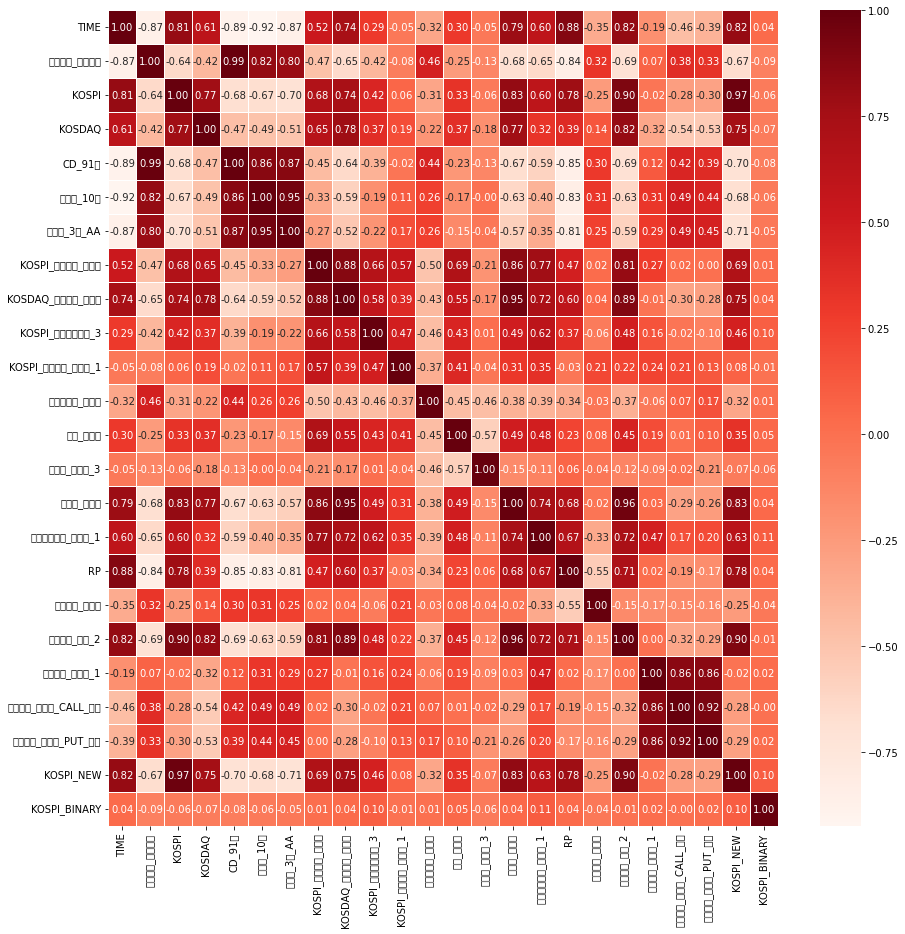

In [11]:
## heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(data = ecos_corr, annot=True, fmt='.2f', linewidths=.5, cmap='Reds')

In [12]:
'''
높은 상관관계가 있는 칼럼 추출
'''

threshholds = 0.2

# 필수 포함 feature: based on 도메인지식
#nece_ftrs = ['한국은행_기준금리', 'KOSPI_yoy', '국고채_10년_yoy', 'KOSPI_주가이익비율_3_yoy', 'KOSPI_BINARY']
nece_ftrs = ['한국은행_기준금리', 'KOSPI', '국고채_10년', 'KOSPI_주가이익비율_3', 'KOSPI_BINARY']
kospi_corr = ecos_corr['KOSPI_NEW']
#kosdaq_corr = ecos_corr['KOSDAQ_NEW']

# 불필요한 칼럼 삭제
kospi_corr.drop(labels=['TIME', 'KOSPI_NEW'], axis='index', inplace=True)
#kosdaq_corr.drop(labels=['TIME', 'KOSPI_NEW', 'KOSDAQ_NEW'], axis='index', inplace=True)

# threshholds 기준에 부합하는 칼럼 출력
kospi_ftrs = list(kospi_corr[(kospi_corr>=threshholds) | (kospi_corr<=-threshholds)].keys())
#kosdaq_ftrs = kosdaq_corr[(kosdaq_corr>=0.3) | (kosdaq_corr<=-0.3)].keys()

# 필수 feature가 없을 시 추가
for f in nece_ftrs:
    if f not in kospi_ftrs:
        kospi_ftrs.append(f)

In [13]:
# 상관분석 결과 바탕으로 데이터셋 수정
#kospi_ftrs.insert(0, 'TIME')
#kospi_ftrs.extend(['KOSPI_NEW'])
ecos_df = ecos_df[kospi_ftrs]

In [14]:
ecos_df

,한국은행_기준금리,KOSPI,KOSDAQ,CD_91일,국고채_10년,회사채_3년_AA,KOSPI_거래대금_일평균,KOSDAQ_거래대금_일평균,KOSPI_주가이익비율_3,기관투자자_순매수,개인_순매수,투자자_예탁금,파생상품거래_예수금_1,RP,위탁매매_미수금,신용융자_잔고_2,거래대금_일평균_CALL_옵션,거래대금_일평균_PUT_옵션,KOSPI_BINARY
0,0.684211,0.150785,0.523719,0.651852,0.905858,0.557803,0.133986,0.128401,0.110236,0.660705,0.172458,0.080661,0.019894,0.000487,0.994870,0.005722,0.212613,0.125723,0.0
1,0.736842,0.138142,0.512937,0.670370,0.843096,0.533237,0.073347,0.090498,0.108993,0.721468,0.211550,0.064424,0.008211,0.001543,1.000000,0.005518,0.204223,0.150988,0.0
2,0.736842,0.132774,0.489471,0.674074,0.872385,0.528902,0.034976,0.068318,0.104849,0.725261,0.208304,0.050511,0.001297,0.000000,0.731455,0.004496,0.101806,0.094471,1.0
3,0.736842,0.159694,0.517151,0.685185,0.878661,0.520231,0.064868,0.077548,0.133858,0.711395,0.185593,0.083090,0.002425,0.003498,0.805738,0.005678,0.187208,0.086090,0.0
4,0.736842,0.114015,0.441979,0.690741,0.826360,0.492775,0.052435,0.050821,0.098632,0.784206,0.261097,0.043003,0.047697,0.003992,0.462610,0.004466,0.194498,0.152607,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0.052632,0.854051,0.937060,0.083333,0.240586,0.095376,0.384382,0.681778,0.239536,0.717829,0.320441,0.941931,0.747508,0.968454,0.094060,0.963737,0.113237,0.148818,0.0
190,0.105263,0.795102,0.900527,0.100000,0.232218,0.122832,0.382876,0.795261,0.219644,0.637877,0.159406,0.929911,0.776359,0.948874,0.152658,0.940149,0.100905,0.119428,1.0
191,0.105263,0.857171,0.994048,0.118519,0.196653,0.111272,0.307691,0.701862,0.176129,0.800442,0.000000,0.954787,0.704850,0.864489,0.151241,0.925292,0.169232,0.098858,0.0
192,0.157895,0.716455,0.773606,0.140741,0.259414,0.143064,0.364686,0.576084,0.152093,0.581643,0.374699,1.000000,0.822928,0.935625,0.139390,0.867558,0.156128,0.183374,1.0
